In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
from faster_rcnn.utils.cython_bbox import bbox_overlaps
from pycrayon import CrayonClient

import cPickle
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show

In [3]:
with open('sorted_index', 'rb') as fp:
    sorted_index = cPickle.load(fp)

### Đọc dữ liệu từ MS COCO dataset


In [4]:
from faster_rcnn.utils.datasets.adapter import convert_data

In [5]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.datasets.mscoco.dataset import CocoData
from torch.utils.data import DataLoader



dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
batch_size = 8

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir, annFile = annFile,sorted_indexes=sorted_index)

train_data_loader = DataLoader(cap, batch_size=batch_size, shuffle=False, collate_fn=convert_data, num_workers=0, drop_last=True)

loading annotations into memory...
Done (t=11.87s)
creating index...
index created!


In [6]:
train_data_loader.batch_size
print len(train_data_loader)

10347


Thử hiển thị ảnh cùng các bounding boxes

In [7]:
from faster_rcnn.faster_rcnn import FastRCNN


### Tính toán feed-forward


Chúng ta sử dụng một ảnh có kích thước đầu vào là  `(width , height) = (600, 800)`

Input:
    - im_data : 
        kích thước : (batch_size, dim, witdh, height)
    - ground_boxes: 
        kích thước (n, 4)
        

In [8]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [9]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anh/.torch/models/vgg16-397923af.pth
100.0%
/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [10]:
param = filter(lambda x: x.requires_grad, net.parameters())
optimizer = RMSprop(param, lr=1e-5, momentum=0.9, weight_decay=0.00005)
exp_lr_scheduler = StepLR(optimizer, step_size=5000, gamma=0.95)

In [14]:
def train(data_gen ,model, tensorboard_client, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss , cross_entropy , loss_box, rpn_loss = metters
    for step, blobs in enumerate(data_gen):
        batch_tensor, im_info, batch_boxes, batch_boxes_index, _ = blobs
        cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        rpn_cross_entropy, rpn_bbox_loss = model.rpn.build_loss(rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target)
        cross_entropy, bbox_loss = model.build_loss(cls_score, bbox_pred, target)
        loss = rpn_cross_entropy + rpn_bbox_loss * 10 + cross_entropy + bbox_loss * 10
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_loss.update(loss.item())     

        current_step = current_epoch * steps_per_epoch + step
        if step % 10 == 1:
            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)

        if step % 100 == 0:
            tensorboard_client.add_scalar_value('train_loss', train_loss.avg, step=current_step)
        
        del loss, rpn_cross_entropy , rpn_bbox_loss , cross_entropy , bbox_loss, cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target


In [15]:
def training(train_data_gen, optimizer, lr_scheduler ,model, epochs=10):
    
    exp_name = datetime.now().strftime('vgg16_mscoco_%m-%d_%H-%Ms')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    
    train_loss = AverageMeter()
    cross_entropy = AverageMeter()
    loss_box = AverageMeter()
    rpn_loss = AverageMeter()
    metters = (train_loss , cross_entropy , loss_box, rpn_loss)

    for epoch in range(epochs):
        train(train_data_gen ,model, exp, metters, optimizer, lr_scheduler, epoch)
        torch.save(net.state_dict(), './checkpoints/faster_model_at_%d.pkl' % epoch) 

In [ ]:
training(train_data_loader ,optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=5)

epoch: 1 : step 1,  loss: 2.6130 at 12/07_09:10
epoch: 1 : step 11,  loss: 2.3306 at 12/07_09:10
epoch: 1 : step 21,  loss: 2.1524 at 12/07_09:11
epoch: 1 : step 31,  loss: 2.0676 at 12/07_09:11
epoch: 1 : step 41,  loss: 2.0398 at 12/07_09:11
epoch: 1 : step 51,  loss: 2.0024 at 12/07_09:11
epoch: 1 : step 61,  loss: 1.9757 at 12/07_09:12
epoch: 1 : step 71,  loss: 1.9846 at 12/07_09:12
epoch: 1 : step 81,  loss: 1.9680 at 12/07_09:12
epoch: 1 : step 91,  loss: 1.9442 at 12/07_09:12
epoch: 1 : step 101,  loss: 1.9355 at 12/07_09:13
epoch: 1 : step 111,  loss: 1.9282 at 12/07_09:13
epoch: 1 : step 121,  loss: 1.9232 at 12/07_09:13
epoch: 1 : step 131,  loss: 1.9202 at 12/07_09:13
epoch: 1 : step 141,  loss: 1.9179 at 12/07_09:13
epoch: 1 : step 151,  loss: 1.9147 at 12/07_09:14
epoch: 1 : step 161,  loss: 1.9123 at 12/07_09:14
epoch: 1 : step 171,  loss: 1.9043 at 12/07_09:14
epoch: 1 : step 181,  loss: 1.9035 at 12/07_09:14
epoch: 1 : step 191,  loss: 1.9017 at 12/07_09:15
epoch: 1 : 

epoch: 1 : step 1631,  loss: 1.8096 at 12/07_09:45
epoch: 1 : step 1641,  loss: 1.8096 at 12/07_09:45
epoch: 1 : step 1651,  loss: 1.8106 at 12/07_09:45
epoch: 1 : step 1661,  loss: 1.8108 at 12/07_09:46
epoch: 1 : step 1671,  loss: 1.8113 at 12/07_09:46
epoch: 1 : step 1681,  loss: 1.8116 at 12/07_09:46
epoch: 1 : step 1691,  loss: 1.8114 at 12/07_09:46
epoch: 1 : step 1701,  loss: 1.8115 at 12/07_09:46
epoch: 1 : step 1711,  loss: 1.8124 at 12/07_09:47
epoch: 1 : step 1721,  loss: 1.8127 at 12/07_09:47
epoch: 1 : step 1731,  loss: 1.8125 at 12/07_09:47
epoch: 1 : step 1741,  loss: 1.8134 at 12/07_09:47
epoch: 1 : step 1751,  loss: 1.8141 at 12/07_09:47
epoch: 1 : step 1761,  loss: 1.8154 at 12/07_09:48
epoch: 1 : step 1771,  loss: 1.8163 at 12/07_09:48
epoch: 1 : step 1781,  loss: 1.8169 at 12/07_09:48
epoch: 1 : step 1791,  loss: 1.8174 at 12/07_09:48
epoch: 1 : step 1801,  loss: 1.8177 at 12/07_09:48
epoch: 1 : step 1811,  loss: 1.8177 at 12/07_09:49
epoch: 1 : step 1821,  loss: 1.

epoch: 1 : step 3241,  loss: 1.8498 at 12/07_10:18
epoch: 1 : step 3251,  loss: 1.8503 at 12/07_10:18
epoch: 1 : step 3261,  loss: 1.8506 at 12/07_10:18
epoch: 1 : step 3271,  loss: 1.8504 at 12/07_10:18
epoch: 1 : step 3281,  loss: 1.8506 at 12/07_10:19
epoch: 1 : step 3291,  loss: 1.8509 at 12/07_10:19
epoch: 1 : step 3301,  loss: 1.8509 at 12/07_10:19
epoch: 1 : step 3311,  loss: 1.8515 at 12/07_10:19
epoch: 1 : step 3321,  loss: 1.8522 at 12/07_10:20
epoch: 1 : step 3331,  loss: 1.8526 at 12/07_10:20
epoch: 1 : step 3341,  loss: 1.8530 at 12/07_10:20
epoch: 1 : step 3351,  loss: 1.8532 at 12/07_10:20
epoch: 1 : step 3361,  loss: 1.8537 at 12/07_10:20
epoch: 1 : step 3371,  loss: 1.8539 at 12/07_10:21
epoch: 1 : step 3381,  loss: 1.8543 at 12/07_10:21
epoch: 1 : step 3391,  loss: 1.8546 at 12/07_10:21
epoch: 1 : step 3401,  loss: 1.8549 at 12/07_10:21
epoch: 1 : step 3411,  loss: 1.8552 at 12/07_10:22
epoch: 1 : step 3421,  loss: 1.8555 at 12/07_10:22
epoch: 1 : step 3431,  loss: 1.

In [22]:
torch.save(net.state_dict(), './checkpoints/faster_model.pkl') 

In [17]:
import gc, inspect
def _get_tensors(gpu_only=True):
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                tensor = obj
            elif hasattr(obj, 'data') and torch.is_tensor(obj.data):
                tensor = obj.data
            else:
                continue

            if tensor.is_cuda:
                yield tensor
        except Exception as e:
            pass

def find_names(obj):
    frame = inspect.currentframe()
    for frame in iter(lambda: frame.f_back, None):
        frame.f_locals
    obj_names = []
    for referrer in gc.get_referrers(obj):
        if isinstance(referrer, dict):
            for k, v in referrer.items():
                if v is obj:
                    obj_names.append(k)
    return obj_names

In [23]:
torch.cuda.empty_cache()

In [24]:
for obj in _get_tensors():
    print type(obj), obj.shape
    print find_names(obj)

<class 'torch.Tensor'> torch.Size([8, 48, 56, 37])
['rpn_bbox_pred', 'obj']
<class 'torch.Tensor'> torch.Size([8, 24, 56, 37])
['rpn_cls_prob_reshape', 'obj']
<class 'torch.Tensor'> torch.Size([8, 1, 672, 37])
['obj']
<class 'torch.Tensor'> torch.Size([8, 48, 56, 37])
['obj']
<class 'torch.Tensor'> torch.Size([8, 48, 56, 37])
['obj']
<class 'torch.Tensor'> torch.Size([8, 48, 56, 37])
['obj']
<class 'torch.Tensor'> torch.Size([1600, 5])
['rois', 'obj']
<class 'torch.Tensor'> torch.Size([1600, 1])
['obj']
<class 'torch.Tensor'> torch.Size([1600, 324])
['obj']
<class 'torch.Tensor'> torch.Size([1600, 324])
['obj']
<class 'torch.Tensor'> torch.Size([1600, 324])
['obj']
<class 'torch.Tensor'> torch.Size([1600, 4096])
['noise', 'obj']
<class 'torch.Tensor'> torch.Size([1600, 4096])
['noise', 'obj']
<class 'torch.Tensor'> torch.Size([1600, 81])
['cls_score', 'obj']
<class 'torch.Tensor'> torch.Size([1600, 81])
['cls_prob', 'obj']
<class 'torch.Tensor'> torch.Size([1600, 324])
['bbox_pred', 'o

<class 'torch.Tensor'> torch.Size([4096])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([4096, 4096])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([4096])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([81, 4096])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([81])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([324, 4096])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([324])
['obj', 'square_avg']
<class 'torch.Tensor'> torch.Size([8, 512, 37, 37])
['obj']


In [25]:
gc.collect()

73478

In [10]:
net.load_state_dict(torch.load('./checkpoints/faster_model.pkl'))

(u'person', (1.7964492341837186, 490.35163962442385), (42.715222663979, 558.6905335328657))
(u'potted plant', (0.0, 344.3019772788707), (53.058442527464756, 417.36141820351577))
(u'person', (0.4893493073086894, 517.1419403301317), (44.46473903974024, 582.6682907188459))
(u'potted plant', (0.0, 53.535450284226386), (153.5809644186565, 325.36833578440303))
(u'person', (823.3432731070442, 9.13218085375371), (895.2123948710379, 144.65530982343893))
(u'person', (3.0372211556399904, 473.4561170749282), (87.02294284791338, 576.5546076767334))
(u'person', (3.271015922443109, 484.0857006880783), (55.06580340264331, 533.8499951024655))


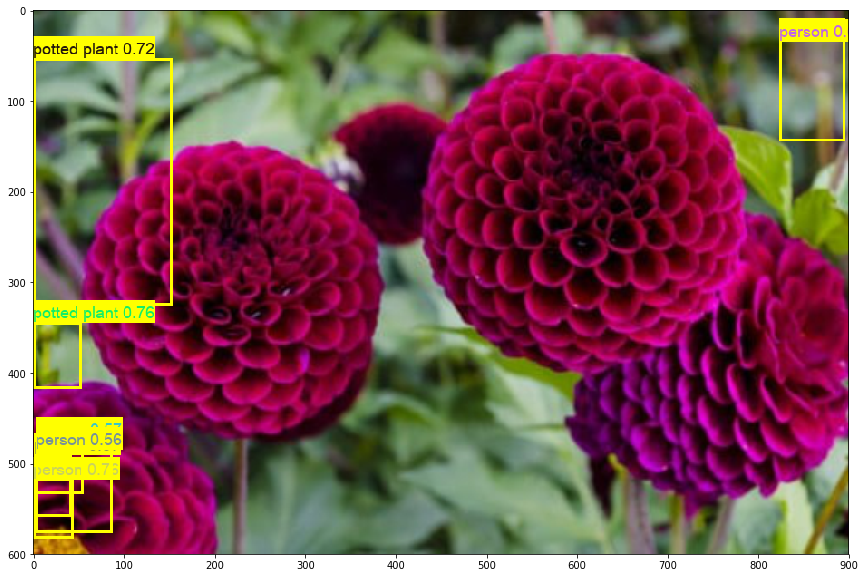

In [30]:
pred_boxes, scores, classes, rois, im_data = net.detect("./test_im/650.jpg", thr=0.5)
result_show(im_data[0], pred_boxes, classes, scores)

In [ ]:
print 1

In [ ]:
__